In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install catboost

     |████████████████████████████████| 69.2 MB 10 kB/s 


In [3]:
import pandas as pd
import numpy as np
path = '/content/drive/MyDrive/parking/'

train = pd.read_csv(path + "train_removed_error.csv")
test = pd.read_csv(path + "test_removed_error.csv")
age = pd.read_csv(path + "age_gender_info.csv")

In [4]:
# 그래프를 통해 확인한 불필요한 데이터 인덱스 찾기
drop_index = train[train["자격유형"] == "O"].index
drop_index

Int64Index([2535], dtype='int64')

In [5]:
# 불필요한 데이터 인덱스 제거
train = train.drop(drop_index)

In [6]:
all_data = pd.concat([train,test])

In [7]:
pd.options.display.max_columns = 9999
all_data = pd.merge(all_data, age, how = "left" ,on = "지역")

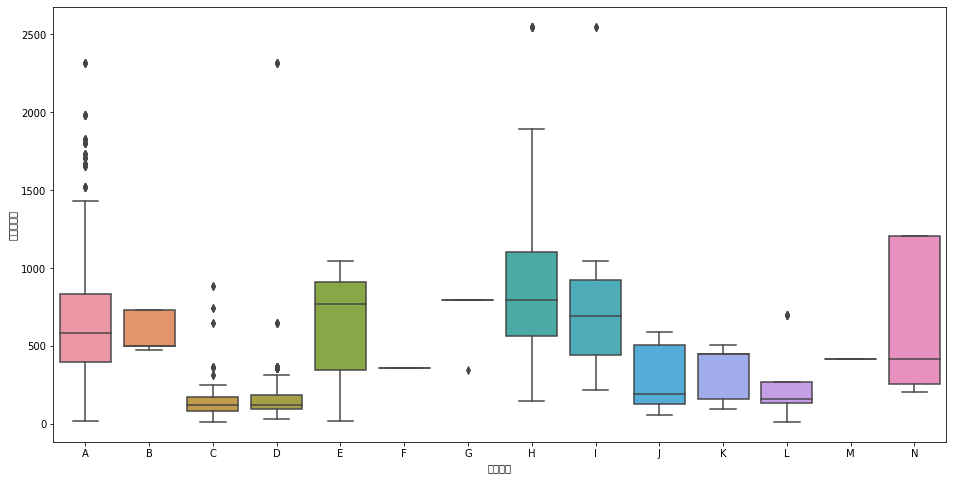

In [8]:
import warnings
warnings.filterwarnings(action='ignore') 
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (16,8))
sns.boxplot(all_data["자격유형"],  all_data["등록차량수"])

##### 불필요한 데이터 제거(전) [위와 비교]

In [9]:
# boxplot을 찍어본 후 "자격유형"이 F, M, O인 데이터를 확인해보았다.

In [10]:
# all_data[all_data["자격유형"] == "F"] # 데이터 3개

In [11]:
# all_data[all_data["자격유형"] == "M"] # 데이터 4개

In [12]:
# all_data[all_data["자격유형"] == "O"] # 데이터 1개로 "자격유형"이 "O"인 데이터는 1개 뿐이어서, 3번째 코드인 train에서 drop 시켜주었다.

#### 파생변수

In [13]:
# 전체적인 카테고리 칼럼에 대한 간접적인 정보를 한번에 추가
cat = all_data.groupby("총세대수")[all_data.columns[all_data.dtypes == "object"]].nunique().add_prefix("nuni")
all_data = all_data.join(cat,on = "총세대수")

In [14]:
# 단지내주차면수 기준으로 전용면적별세대수 세기
car_fm =all_data.groupby("단지내주차면수")["전용면적별세대수"].agg(len).to_frame("car_fm")
all_data = all_data.join(car_fm, on = "단지내주차면수")

In [15]:
# 지역,임대건물구분 기준으로 전용면적의 통계량 추가
region = all_data.groupby(["지역","임대건물구분"])["전용면적"].agg(["count","sum","mean","min","max","median","std"]).add_prefix("r_")
all_data = all_data.join(region, on = ["지역","임대건물구분"])

In [16]:
# 단지코드 기준으로 자격유형의 고유값 개수 세기
type_per = all_data.groupby("단지코드")["자격유형"].nunique().to_frame("type_per")
all_data = all_data.join(type_per, on = "단지코드")

In [17]:
# 공가수와 버스정류장수의 연관성
all_data["va-bus"] = all_data["공가수"] * all_data["도보 10분거리 내 버스정류장 수"]

In [18]:
# 교통 (7월 12일 추가)
all_data["traffic"] = np.where(((all_data["도보 10분거리 내 버스정류장 수"] == 6) | (all_data["도보 10분거리 내 지하철역 수(환승노선 수 반영)"] == 2)),1,0)

In [19]:
pd.options.display.max_rows = 999
all_data.corr()["등록차량수"].sort_values(ascending=False)

등록차량수                           1.000000
단지내주차면수                         0.856578
r_median                        0.492554
30대(여자)                         0.384518
30대(남자)                         0.369884
총세대수                            0.321836
40대(남자)                         0.320829
r_count                         0.289135
r_sum                           0.282399
10대미만(남자)                       0.274498
10대미만(여자)                       0.268184
전용면적별세대수                        0.254915
traffic                         0.224822
40대(여자)                         0.186069
r_min                           0.164137
va-bus                          0.150583
100대(여자)                        0.135110
공가수                             0.131044
도보 10분거리 내 버스정류장 수              0.110917
전용면적                            0.106369
10대(여자)                         0.017408
20대(여자)                         0.008146
100대(남자)                        0.006206
r_mean                         -0.001786
nuni임대료         

In [20]:
all_data2 = all_data.drop(columns=["단지코드"])

In [21]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in all_data2.columns[all_data2.dtypes == "object"]:
    all_data2[i] = le.fit_transform(list(all_data2[i]))

In [22]:
train2 = all_data2[:len(train)]
test2 = all_data2[len(train):]

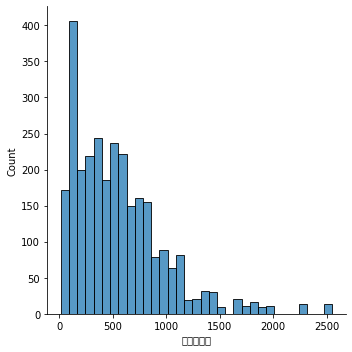

In [23]:
# 데이터의 분포를 확인해보니, y값의 분포가 왼쪽으로 편향되어 있다.
import seaborn as sns
sns.displot(train["등록차량수"])

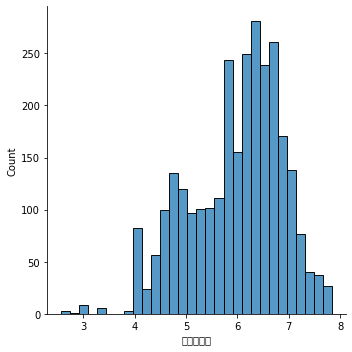

In [24]:
# log를 씌어줌으로써 x의 범위도 줄어들고, 데이터의 분포가 안정적이게 된다.
sns.displot(np.log(train["등록차량수"]))

In [25]:
train2 = train2.fillna(0)
test2 = test2.fillna(0)

In [26]:
!pip install optuna

     |████████████████████████████████| 301 kB 6.6 MB/s 
     |████████████████████████████████| 80 kB 6.0 MB/s 
     |████████████████████████████████| 164 kB 10.6 MB/s 
     |████████████████████████████████| 75 kB 4.6 MB/s 
     |████████████████████████████████| 49 kB 6.5 MB/s 
     |████████████████████████████████| 111 kB 12.5 MB/s 
     |████████████████████████████████| 141 kB 11.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=83e79c6a7e4f48cb4a54a3ec91810c041c9444f33050fb9d93d4edf319d9acb5
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [27]:
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

In [52]:
def objective(trial: Trial) -> float:
    params_lgb = {
    'n_estimators': trial.suggest_int("n_estimators", 1, 100000),
    'criterion': 'mae',
    'max_depth': trial.suggest_int("max_depth", 1, 16),
    #'min_sample_split': trial.suggest_int("min_sample_split", 1, 8),
    #'min_sample_leaf': trial.suggest_int("min_sample_leaf", 1, 8)
    }
    

    
    result = 0
    best_score = 0
    from sklearn.model_selection import KFold
    from sklearn.ensemble import ExtraTreesClassifier
    from catboost import CatBoostRegressor
    kf = KFold(n_splits = 5, shuffle = True, random_state = 82)
    for train_index, valid_index in kf.split(train2):
        X_train, X_valid = train2.iloc[train_index], train2.iloc[valid_index]
        y_train, y_valid = np.log(train["등록차량수"]).iloc[train_index], np.log(train["등록차량수"]).iloc[valid_index]
        cbr = ExtraTreesClassifier(**params_lgb)
        cbr.fit(X_train,y_train)
        result += cbr.predict(test2) / 5
        best_score += cbr.best_score_["validation"]["MAE"] / 5


    return best_score

In [29]:
# def objective(trial: Trial) -> float:
#     params_lgb = {
#     'iterations': trial.suggest_int("iterations", 1, 100000),
#     'learning_rate': trial.suggest_float("learning_rate", 1e-8, 0.1),
#     'eval_metric': 'MAE',
#     'random_seed': 42,
#     'logging_level': 'Silent',
#     'use_best_model': True,
#     'loss_function': 'MAE',
#     'od_type': 'Iter',
#     'od_wait': trial.suggest_int("od_wait", 1, 10000),
#     'one_hot_max_size': trial.suggest_int("one_hot_max_size", 1, 10000),
#     'l2_leaf_reg': trial.suggest_int("l2_leaf_reg", 1, 15),
#     'depth': trial.suggest_int("l2_leaf_reg", 1, 15),
#     'rsm': trial.suggest_float("rsm", 0.1, 0.9),
#     'random_strength': trial.suggest_int("random_strength", 1, 10000),
#     'bagging_temperature': trial.suggest_int("bagging_temperature", 1, 10000),
#     }
    

    
#     result = 0
#     best_score = 0
#     from sklearn.model_selection import KFold
#     from sklearn.ensemble import ExtraTreesClassifier
#     from catboost import CatBoostRegressor
#     kf = KFold(n_splits = 5, shuffle = True, random_state = 82)
#     for train_index, valid_index in kf.split(train2):
#         X_train, X_valid = train2.iloc[train_index], train2.iloc[valid_index]
#         y_train, y_valid = np.log(train["등록차량수"]).iloc[train_index], np.log(train["등록차량수"]).iloc[valid_index]
#         cbr = CatBoostRegressor(**params_lgb)
#         cbr.fit(X_train,y_train,eval_set=(X_valid,y_valid),early_stopping_rounds=50,cat_features = [1,2,3,7])
#         result += cbr.predict(test2) / 5
#         best_score += cbr.best_score_["validation"]["MAE"] / 5


#     return best_score

In [53]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="catboost_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=5)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2021-07-27 05:34:54,178] A new study created in memory with name: catboost_parameter_opt
[W 2021-07-27 05:34:54,197] Trial 0 failed because of the following error: ValueError("Unknown label type: 'continuous'")
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/optuna/_optimize.py", line 216, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-52-004ddf35a6ea>", line 22, in objective
    cbr.fit(X_train,y_train)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 321, in fit
    "(n_samples,), for example using ravel().",
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 541, in _validate_y_class_weight
    warn("Some inputs do not have OOB scores. "
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/multiclass.py", line 169, in check_classification_targets
    def check_classification_targets(y):
ValueError: Unknown label type: 'continuous'


ValueError: ignored

In [31]:
# # 학습 시 정답값에 log를 씌어주었다.
# result = 0
# best_score = 0
# from sklearn.model_selection import KFold
# from sklearn.ensemble import ExtraTreesClassifier
# from catboost import CatBoostRegressor
# kf = KFold(n_splits = 5, shuffle = True, random_state = 82)
# for train_index, valid_index in kf.split(train2):
#     X_train, X_valid = train2.iloc[train_index], train2.iloc[valid_index]
#     y_train, y_valid = np.log(train["등록차량수"]).iloc[train_index], np.log(train["등록차량수"]).iloc[valid_index]
#     cbr = CatBoostRegressor(verbose = 1 ,eval_metric = "MAE",iterations = 45607,learning_rate = 0.002911)
#     cbr.fit(X_train,y_train,eval_set=(X_valid,y_valid),early_stopping_rounds=50,cat_features = [1,2,3,7])
#     result += cbr.predict(test2) / 5
#     best_score += cbr.best_score_["validation"]["MAE"] / 5

In [32]:
# result

In [33]:
!pip install catboost
!pip install kaggler
!pip install pendulum
!pip install flaml
!pip install shap

     |████████████████████████████████| 822 kB 7.6 MB/s 
  Created wheel for kaggler: filename=Kaggler-0.9.13-cp37-cp37m-linux_x86_64.whl size=2963690 sha256=d00799549ab227f6495403a2ee080d139913f52b1c408e90d574e4483cc58062
  Stored in directory: /root/.cache/pip/wheels/64/38/23/298e2f6a012a8ae187cf100410865a2cdd434aed5a75a42cfe
  Created wheel for ml-metrics: filename=ml_metrics-0.1.4-py3-none-any.whl size=7844 sha256=113fe03445325529ec017f5c5cd8ae086cba6b0c3bd3cd424b4ee57daaba433c
  Stored in directory: /root/.cache/pip/wheels/56/41/5b/0c6d42b3604a5c823d8922564c4708f84962fa7f2f4facfa6d
Successfully built kaggler ml-metrics
     |████████████████████████████████| 155 kB 7.4 MB/s 
     |████████████████████████████████| 489 kB 11.8 MB/s 
     |████████████████████████████████| 206 kB 7.2 MB/s 
     |████████████████████████████████| 22.3 MB 1.5 MB/s 
     |████████████████████████████████| 2.0 MB 44.8 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-lea

     |████████████████████████████████| 356 kB 8.7 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491629 sha256=273e8069596a7562acfb8652ea13ebe31b591803ecb6a583af47d29fab51166f
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [34]:
# import numpy as np
# import shap
# def get_columns(model, X_test, train, del_col_nm='석식계'):
#   explainer = shap.Explainer(model._model)
#   shap_values = explainer(X_test)
#   vals = np.abs(shap_values.values).mean(0)
#   cols = list(train.columns)
#   cols.remove(del_col_nm)
#   feature_importance = pd.DataFrame(list(zip(cols, vals)), columns=['col_name','feature_importance_vals'])
#   feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
#   return feature_importance[feature_importance['feature_importance_vals'] > 1]['col_name'].values

In [35]:
# from sklearn.model_selection import KFold
# from sklearn.preprocessing import StandardScaler

# def run_kfold(train, test, selected_cols=[], target_col='중식계'):
#     folds=KFold(n_splits=5, shuffle=True, random_state=2021)
#     outcomes=[]
#     model = None
#     sub=[]

#     # X = None
#     # X_test = None
#     # if len(selected_cols) > 0:
#     #   X = np.array(train[selected_cols])
#     #   X_test = np.array(test[selected_cols])
#     # else:
#     #   X = np.array(train.drop(columns=[target_col]))
#     #   cols = list(train.columns)
#     #   cols.remove(target_col)
#     #   X_test = np.array(test[cols])

#     # y = np.array(train[target_col])
#     X = np.array(train.drop(columns=[target_col]))
#     cols = list(train.columns)
#     cols.remove(target_col)
#     X_test = np.array(test[cols])
#     y = np.array(train[target_col])

#     # 정규화
#     standardScaler = StandardScaler()
#     standardScaler.fit(X)
#     X = standardScaler.transform(X)

#     X_test = standardScaler.transform(X_test) # 정규화
#     cols_import = []

#     for n_fold, (train_index, val_index) in enumerate(folds.split(X)):
#         print(n_fold, 'fold started =========================================')
#         # X_train1, X_val = , X_train.loc[val_index]
#         y_train = y[train_index]
#         X_train = X[train_index]
#         # y_train1, y_val = y_train.loc[train_index], y_train.loc[val_index]
#         y_val = y[val_index]
#         X_val = X[val_index]
#         if n_fold == 0:
#           automl = AutoML()
#           automl_settings = {
#               "time_budget": 120,  # in seconds
#               "metric": 'mae',
#               "task": 'regression'
#           }
#           automl.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, **automl_settings)
#           model = automl.model
#         else:
#           model.fit(X_train, y_train) 
        
#         pred1 = model.predict(X_test)
#         if len(selected_cols) == 0:
#           cols_import += list(get_columns(model, X_test, train=train, del_col_nm=target_col))
#         sub.append(pred1)
#     return sub, model, X_test, set(cols_import)

In [36]:
# my_submission, model, X_test, cols_import = run_kfold(train2, test2, selected_cols=[], target_col='등록차량수')

In [37]:
# pred1 = np.mean(my_submission, axis=0)

In [38]:
# sample_submission = pd.read_csv(path+'sample_submission.csv')
# submission = sample_submission.copy()

#### 내부 평가셋 점수

In [39]:
# best_score # 0.01846 # 0.01972

In [40]:
# # 학습 시 정답값에 log를 씌어주었기 때문에 결과값에 exp를 씌어 지수화 해준다.
# result_df = pd.DataFrame({"단지코드":test["단지코드"],"result":np.exp(result)})
# a = result_df.groupby("단지코드")["result"].mean().reset_index().rename(columns={"단지코드":"code"})

In [41]:
# sub = pd.read_csv(path+ "sample_submission.csv")
# sub = pd.merge(sub, a , on = "code", how = "left")
# sub = sub.drop(columns = "num")
# sub.columns = ["code","num"]
# sub

In [42]:
# sub.to_csv(path + "catboost_optuna.csv",index=False)